<a href="https://colab.research.google.com/github/pnatarajan01/policyrecon/blob/master/NER_PolicyTagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import numpy as np
import spacy
import random

In [ ]:
def cleansing_trainingdata(x):
  if (x==''):
    return x
  else:
    return str(x).strip()

In [ ]:
training_df=pd.read_excel("/content/drive/My Drive/Training_data_validate2.xlsx")
training_df['Sentence'] = training_df['Sentence'].apply(lambda x: str(x))
training_df['Policy'] = training_df['Policy'].apply(lambda x: cleansing_trainingdata(x))
training_df=training_df.drop_duplicates(['Sentence', 'Policy'])
training_df['Policy'] = training_df.groupby(['Sentence']).transform(lambda x: '|'.join(x))
training_df=training_df.drop_duplicates(['Sentence', 'Policy'])

In [ ]:
TRAIN_DATA = []

for index, row in training_df.iterrows():
    row['Sentence']=str(row['Sentence']).replace('\'', "").strip()
    policy = str(row['Policy'])
    policies = policy.split("|")
    ents=[]
    
    for policy in policies:
      policy = policy.strip()

    policies.sort()

    for policy in policies:
      if policy != 'nan':
        begIndex = row['Sentence'].find(policy)
        begIndices = [i for i in range(len(row['Sentence'])) if row['Sentence'].startswith(policy, i)]
        for begIndex in begIndices:
          endIndex = begIndex+len(policy)
          ents.append((begIndex,endIndex,'POLICY'))
    ents = list(set(ents))

    entities = {}
    entities["entities"]=ents
    TRAIN_DATA.append((row['Sentence'],entities))

In [ ]:
def train_spacy(data,iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('en')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)
            print(losses)
    return nlp

In [ ]:
TRAIN_DATA

[('Document training required by this AFJQS in accordance with AFI36-2201, Air Force Training Program.',
  {'entities': [(60, 70, 'POLICY')]}),
 ('This Instruction implements Air Force Policy Directive (AFPD) 10-2, Readiness, and is consistent with AFPD 10-8, Homeland Security.',
  {'entities': [(55, 66, 'POLICY')]}),
 ('It describes policy and requirements for implementing DODI 3020.42, Defense Continuity Plan Development, and DODI O-3020.43, Emergency Management and Incident Command of the Pentagon Facilities; DODI O-3000.08 Balanced Survivability Assessments (BSAs);and O-DODI 5110.11, Raven Rock Mountain Complex (RRMC).',
  {'entities': [(54, 66, 'POLICY'),
    (258, 270, 'POLICY'),
    (195, 209, 'POLICY'),
    (109, 123, 'POLICY')]}),
 ('Ensure that all records created as a result of processes prescribed in this publication are maintained in accordance with AFMAN 33-363, Management of Records, and disposed of in accordance with the Air Force Records Disposition Schedule (RDS) loca

In [ ]:
prdnlp = train_spacy(TRAIN_DATA, 40)

Starting iteration 0
{'ner': 2222.8055157463464}
Starting iteration 1
{'ner': 1455.6099530413405}
Starting iteration 2
{'ner': 982.4438156394694}
Starting iteration 3
{'ner': 1300.305622504097}
Starting iteration 4
{'ner': 992.7674347735745}
Starting iteration 5
{'ner': 831.3889512265498}
Starting iteration 6
{'ner': 808.0115567801181}
Starting iteration 7
{'ner': 816.3424195218095}
Starting iteration 8
{'ner': 674.7025965844286}
Starting iteration 9
{'ner': 669.7807997817401}
Starting iteration 10
{'ner': 447.22791003029215}
Starting iteration 11
{'ner': 375.011442529964}
Starting iteration 12
{'ner': 366.9541988616584}
Starting iteration 13
{'ner': 418.01858165539505}
Starting iteration 14
{'ner': 445.59545466449003}
Starting iteration 15
{'ner': 345.210247655229}
Starting iteration 16
{'ner': 344.05971268945615}
Starting iteration 17
{'ner': 307.438990141351}
Starting iteration 18
{'ner': 339.1661292853696}
Starting iteration 19
{'ner': 349.5709869844434}
Starting iteration 20
{'ner

In [ ]:
def create_total_prediction_vector(docs): #return number of times policy was identified in each sentence
    prediction_vector = []
    for doc in docs:
      prediction_vector.append(len(get_all_ner_predictions(doc[0])))
    return prediction_vector

def get_all_ner_predictions(text): # get all NER predictions
    doc = prdnlp(text)
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    return entities

In [ ]:
def create_total_actual_vector(docs): #return number of time policies was identified in each sentence in training set
  actual_vector = []
  for doc in docs:
    actual_vector.append(len(doc[1]['entities']))
  return actual_vector
    

In [ ]:
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(docs): #generate a confusion matrix to identify how accurately training model identifies policies
    y_true = create_total_actual_vector(docs)
    y_pred = create_total_prediction_vector(docs)

    return confusion_matrix(y_true, y_pred, labels=list(set(y_pred)))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


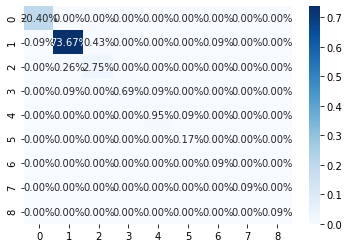

In [ ]:
import seaborn as sns 

#visualize confusion matrix
sns.heatmap(generate_confusion_matrix(TRAIN_DATA)/np.sum(generate_confusion_matrix(TRAIN_DATA)), annot=True, fmt='.2%', cmap='Blues')


In [ ]:
craRelevant_df = pd.read_csv("/content/drive/My Drive/2020-6-25_CRA_Policies_Grouped.csv")


In [ ]:
craRelevant_df = craRelevant_df[['File','New_Paragraph']]
craRelevant_df.columns = ['File','Paragraph']

In [ ]:
def identify_policies(text):
  entities = ""
  div = int(len(text)/4)
  parts = [text[:div],text[div:2*div], text[2*div:3*div],text[3*div:]]
  for part in parts:
    doc = prdnlp(part)
    for e in doc.ents:
      entities += (e.text + "|")
  return entities

In [ ]:
craRelevant_df['Paragraph'] = craRelevant_df['Paragraph'].map(lambda x: re.sub('[^a-zA-Z-–_().\d\s]', '', str(x)))


In [ ]:
craRelevant_df['Identified_Policies'] = craRelevant_df['Paragraph'].apply(identify_policies)
craRelevant_df = craRelevant_df.assign(Identified_Policies=craRelevant_df['Identified_Policies'].str.split('|')).explode('Identified_Policies')

In [ ]:
craRelevant_df.reset_index(inplace=True)

In [ ]:
aggregate=pd.read_csv("/content/drive/My Drive/20200625_final_predict.csv")
aggregate = aggregate[aggregate['Prediction']==1]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
final_df = pd.merge(craRelevant_df, aggregate, on=['File'],how="left")

In [ ]:
metadata = pd.read_csv("/content/drive/My Drive/data_raw_Metadata_All_Policies_Metadata_vF_updated20APR2020.csv")

In [ ]:
final_df = final_df[['Paragraph_x','File','Identified_Policies','Links']]

In [ ]:
metadata=metadata[['Product Number','Organization Level','Issuing Organization','Links']]
metadata = metadata.drop_duplicates(subset='Links', keep='first')
final_df = pd.merge(metadata,final_df,on='Links').drop(['File'],axis=1)

NameError: ignored

In [ ]:
craRelevantPolicies = list(set(final_df['Product Number'].tolist()))

In [ ]:
beg_with_df=pd.read_excel("/content/drive/My Drive/ER_Beg_CleanUp.xlsx")

In [ ]:
def clean_technical_order(x):
  if x.startswith(".O"):
    return "T"+x
  else:
    return x

In [ ]:
def clean_to_relevant(x):
  if (x.find("10 USC")!=-1 or x.find("TITLE 10")!=-1 or x.find("USC 10")!=-1):
    return "TITLE 10"
  elif ((x.find("TITLE ")!=-1)):
    if (re.match('(TITLE \d+)',x) != None):
      return re.match('(TITLE \d+)',x).group(0)
    else:
      return None
  elif ((x.find("POLICY")!=-1) or (x.find("ACT ")!=-1)):
    return x
  elif (x.find("FORM")!=-1):
    return None
  elif any(prefix in x for prefix in tuple(beg_with_df['Prefix'])):
    return x
  else:
    return None

In [ ]:
def final_clean(x):
  if x.startswith(("DODD DODD",'AFPD AFPD','DODMDODM','DODI DODI')):
    return x[4:].strip()
  elif x.startswith("EO EO"):
    return x[2:].strip()
  elif "AF I" in x:
    return x.replace("AF I", "AFI")
  elif "AF MD" in x:
    return x.replace("AF MD", "AFMD")
  elif "AF PD" in x:
      return x.replace("AF PD", "AFPD")
  else:
    return x

In [ ]:
import warnings
warnings.filterwarnings('ignore')

final_df = final_df[final_df.Identified_Policies.str.contains('^(?=.*[a-zA-Z])(?=.*[0-9])')]
final_df["Identified_Policies"]=final_df["Identified_Policies"].apply(clean_technical_order)
final_df["Identified_Policies"]=final_df["Identified_Policies"].apply(lambda x: re.sub('[.]', '', x.strip().upper()))
final_df["Identified_Policies"]=final_df["Identified_Policies"].apply(lambda x: re.sub('V\d+', '', x.strip().upper()))
final_df["Identified_Policies"]=final_df["Identified_Policies"].apply(lambda x: re.sub('VOLUME\d+', '', x.strip().upper()))
final_df['Identified_Policies']=final_df["Identified_Policies"].apply(lambda x: re.sub('^\d+',"",x.strip()))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: re.sub('[()]', '', x.strip()))

final_df["Product Number"]=final_df["Product Number"].apply(lambda x: re.sub('[.]', '', x.strip().upper()))
final_df["Product Number"]=final_df["Product Number"].apply(lambda x: re.sub('V\d+', '', x.strip().upper()))
final_df["Product Number"]=final_df["Product Number"].apply(lambda x: re.sub('VOLUME\d+', '', x.strip().upper()))
final_df['Product Number']=final_df["Product Number"].apply(lambda x: re.sub('^\d+',"",x.strip()))
final_df['Product Number']=final_df['Product Number'].apply(lambda x: re.sub('[()]', '', x.strip()))

final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.strip().replace("AIR FORCE ","AF"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("SPACE WING ","SW"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("DEPARTMENT OF DEFENSE ","DOD"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("DEPFENSE LOGISTICS ","DL"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("JOINT  ","J"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("INSTRUCTION","I"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("TECHNICAL ORDER","TO"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("EXECUTIVE ORDER","EO"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("TOS","TO"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("MANUAL ","M"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("POLICY DIRECTIVE","PD"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("MISSION DIRECTIVE","MD"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("DIRECTIVE","D"))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: x.replace("REGULATION","R"))
final_df['Identified_Policies']=final_df["Identified_Policies"].apply(final_clean)
final_df['Identified_Policies']=final_df["Identified_Policies"].apply(clean_to_relevant)

final_df=final_df[final_df['Identified_Policies']!=None]


In [ ]:
final_df = final_df.dropna()


In [ ]:
final_df['Product Number']=final_df['Product Number'].apply(lambda x: x.replace(' ', ''))
final_df['Identified_Policies']=final_df['Identified_Policies'].apply(lambda x: str(x).replace(' ', ''))
final_df = final_df[final_df['Identified_Policies']!=final_df['Product Number']]
final_df = final_df[final_df['Identified_Policies']!='nan']

In [ ]:
final_df.columns = ['Product Number', 'Organization Level','Issuing Organization','Links','Paragraph','Identified_Policies']

In [ ]:
final_df=final_df[['Product Number', 'Organization Level','Issuing Organization','Paragraph','Identified_Policies']]

In [ ]:
final_df["Product Number"]=final_df["Product Number"].apply(lambda x: re.sub('VOLUME\d+', '', x.strip().upper()))

In [ ]:
final_df=final_df[final_df['Product Number']!=final_df['Identified_Policies']]

In [ ]:
final_df = final_df[final_df['Identified_Policies'].isin(craRelevantPolicies)]

In [ ]:
uniqueCRApolicies = list(set(final_df['Product Number'].tolist()+final_df['Identified_Policies'].tolist()))

In [ ]:
len(list(set(final_df['Identified_Policies'].tolist())))

249

In [ ]:
metadata['Product Number']=metadata['Product Number'].apply(lambda x: re.sub('[.]', '', x.strip().upper()))
metadata['Product Number']=metadata['Product Number'].apply(lambda x: re.sub('V\d+', '', x.strip().upper()))
metadata['Product Number']=metadata['Product Number'].apply(lambda x: re.sub('VOLUME\d+', '', x.strip().upper()))
nodes = pd.DataFrame(data=uniqueCRApolicies)
nodes.columns = ['Product Number']
nodes = nodes.join(metadata.set_index('Product Number'), on='Product Number').dropna(subset=['Organization Level']).reset_index()
nodes = nodes[['Product Number', 'Organization Level', 'Issuing Organization']].drop_duplicates(subset='Product Number', keep='first')

In [ ]:
nodeList = nodes['Product Number'].tolist()
final_df = final_df[final_df['Product Number'].isin(nodeList)]
final_df = final_df[final_df['Identified_Policies'].isin(nodeList)]

In [ ]:
nodes.columns = ['name','Organization.Level','Issuing.Organization']

In [ ]:
final_df = final_df.groupby(final_df.columns.tolist()).size().reset_index().rename(columns={0:'Weight'})

In [ ]:
final_df

,Product Number,Organization Level,Issuing Organization,Paragraph,Identified_Policies,Weight
0,ACCI10-255,Major Command,ACC,BY ORDER OF THE COMMANDER. AIR COMBAT COMMAND....,AFI10-401,4
1,ACCI10-260_MOUNTAINHOMEAFBSUP,Base,MountainHomeAFB,BY ORDER OF THE COMMANDER. AIR COMBAT COMMAND....,AFI10-2501,2
2,ACCI10-260_MOUNTAINHOMEAFBSUP,Base,MountainHomeAFB,BY ORDER OF THE COMMANDER. AIR COMBAT COMMAND....,AFI24-302,2
3,ACCI17-202,Major Command,ACC,BY ORDER OF THE COMMANDER. AIR COMBAT COMMAND....,AFI16-1007,2
4,ACCI21-105_BEALEAFBSUP_I,Base,BealeAFB,BY ORDER OF THE COMMANDER. AIR COMBAT COMMAND....,AFI21-101,18
...,...,...,...,...,...,...
5331,YOKOTAABI32-2001,Base,YokotaAB,BY ORDER OF THE COMMANDER. YOKOTA AIR BASE. YO...,AFI32-2001,2
5332,YOKOTAABI32-2001,Base,YokotaAB,BY ORDER OF THE COMMANDER. YOKOTA AIR BASE. YO...,AFI90-821,1
5333,YOKOTAABI34-242,Base,YokotaAB,BY ORDER OF THE COMMANDER. 374TH AIRLIFT WING....,AFI36-2903,5
5334,YOKOTAABI36-2655,Base,YokotaAB,BY ORDER OF THE COMMANDER. YOKOTA AIR BASE. YO...,AFI36-2654,50
